In [41]:
!pip install scikit-image scikit-fuzzy

In [42]:
import os, cv2, numpy as np, matplotlib.pyplot as plt, pandas as pd
from glob import glob
from skimage.measure import label, regionprops
from sklearn.cluster import KMeans
import skfuzzy as fuzz

In [43]:
BASE = "/kaggle/input/raabindata-nucleus-cytoplasm-ground-truths/GrTh"
ORIG = os.path.join(BASE,"Original")
GT   = os.path.join(BASE,"Ground Truth")

cell_types = ["Eosinophil","Lymphocyte","Monocyte","Neutrophil"]

In [44]:
def load_pair(cell):

    img_path = glob(os.path.join(ORIG,cell,"**","*.*"), recursive=True)[0]
    mask_path = glob(os.path.join(GT,cell,"**","*.*"), recursive=True)[0]

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path,0)

    img = cv2.resize(img,(224,224))
    mask = cv2.resize(mask,(224,224))

    return img, mask

In [45]:
def extract_wbc(img):

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    B = lab[:,:,2]

    _, th = cv2.threshold(B,0,255,
                          cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((5,5),np.uint8)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)

    labels = label(th)
    regions = regionprops(labels)

    if len(regions)==0:
        None

    # choose central region
    h,w = th.shape
    center = np.array([h//2,w//2])

    best = max(regions,
               key=lambda r: r.area - np.linalg.norm(np.array(r.centroid)-center))

    return (labels==best.label).astype(np.uint8)

In [46]:
def keep_largest(mask):
    labels = label(mask)
    regions = regionprops(labels)
    if len(regions)==0:
        return mask
    largest = max(regions, key=lambda r:r.area)
    return (labels==largest.label).astype(np.uint8)

def fill(mask):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

In [47]:
def kmeans_seg(img, wbc):

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    pixels = lab[wbc==1].reshape(-1,3)

    km = KMeans(n_clusters=2, random_state=0).fit(pixels)
    centers = km.cluster_centers_

    nucleus_cluster = np.argmin(centers[:,0])   # darker = nucleus

    labels_full = np.zeros(wbc.shape)
    labels_full[wbc==1] = km.labels_

    nucleus = (labels_full==nucleus_cluster).astype(np.uint8)
    nucleus = keep_largest(fill(nucleus))

    cytoplasm = wbc - nucleus

    return nucleus, cytoplasm

In [48]:
def fcm_seg(img, wbc):

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    pixels = lab[wbc==1].reshape(-1,3).T

    cntr,u,_,_,_,_,_ = fuzz.cluster.cmeans(
        pixels, c=2, m=2, error=0.005, maxiter=1000)

    labels = np.argmax(u, axis=0)

    labels_full = np.zeros(wbc.shape)
    labels_full[wbc==1] = labels

    nucleus_cluster = np.argmin(cntr[:,0])

    nucleus = (labels_full==nucleus_cluster).astype(np.uint8)
    nucleus = keep_largest(fill(nucleus))

    cytoplasm = wbc - nucleus

    return nucleus, cytoplasm, u

In [49]:
def boundary(mask):
    kernel = np.ones((3,3),np.uint8)
    return cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_GRADIENT, kernel)

def boundary_f1(pred, gt):

    pb = boundary(pred)
    gb = boundary(gt)

    inter = np.logical_and(pb, gb).sum()
    prec = inter / (pb.sum()+1e-8)
    rec  = inter / (gb.sum()+1e-8)

    return 2*prec*rec/(prec+rec+1e-8)

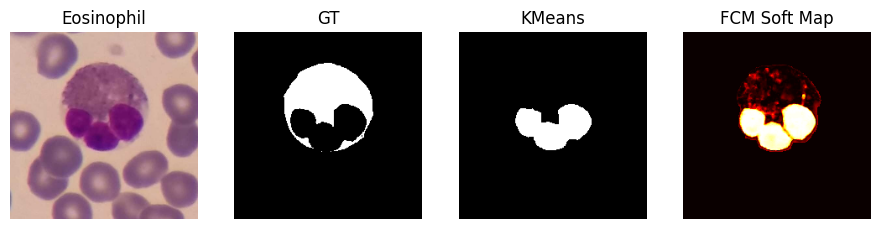

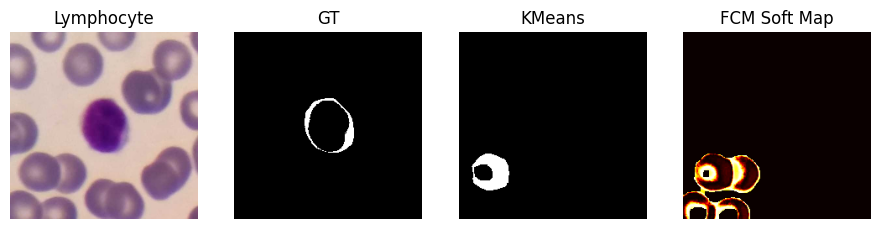

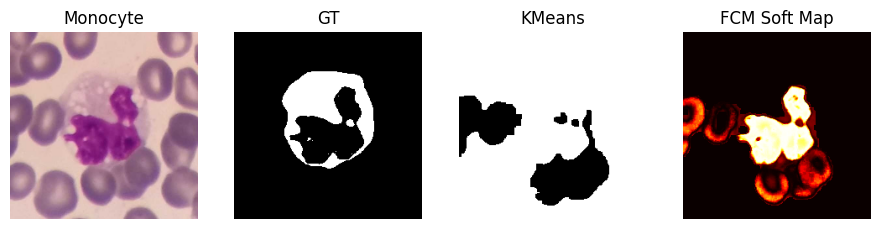

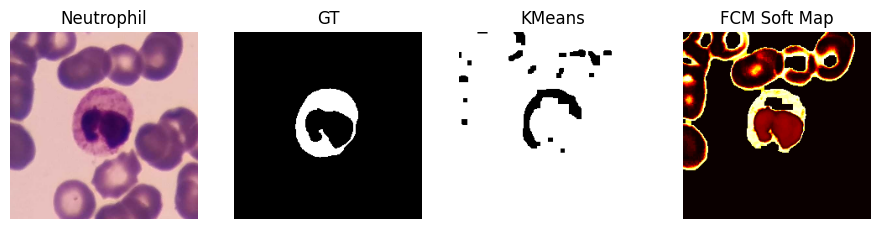

In [50]:
results = []

for cell in cell_types:

    img, gt = load_pair(cell)
    wbc = extract_wbc(img)

    if wbc is None:
        continue

    gt_nucleus = (gt>128).astype(np.uint8)

    km_nuc, km_cyto = kmeans_seg(img, wbc)
    fcm_nuc, fcm_cyto, membership = fcm_seg(img, wbc)

    km_f1 = boundary_f1(km_nuc, gt_nucleus)
    fcm_f1 = boundary_f1(fcm_nuc, gt_nucleus)

    results.append([cell, km_f1, fcm_f1])

    # visualization
    plt.figure(figsize=(14,4))
    plt.subplot(1,5,1); plt.imshow(img); plt.title(cell); plt.axis('off')
    plt.subplot(1,5,2); plt.imshow(gt_nucleus,cmap='gray'); plt.title("GT"); plt.axis('off')
    plt.subplot(1,5,3); plt.imshow(km_nuc,cmap='gray'); plt.title("KMeans"); plt.axis('off')
    plt.subplot(1,5,4); plt.imshow(fcm_nuc,cmap='gray'); plt.title("FCM"); plt.axis('off')
    # choose nucleus cluster
    nucleus_cluster = np.argmin(membership.mean(axis=1))

    # create full-size map
    soft_map = np.zeros(wbc.shape)
    soft_map[wbc==1] = membership[nucleus_cluster]

    plt.imshow(soft_map, cmap='hot')
    plt.title("FCM Soft Map")
    plt.axis('off')
    plt.show()

In [51]:
df = pd.DataFrame(results, columns=["Cell","KM Boundary F1","FCM Boundary F1"])
df

,Cell,KM Boundary F1,FCM Boundary F1
0,Eosinophil,0.422588,0.422588
1,Lymphocyte,0.000000,0.000000
2,Monocyte,0.266080,0.246817
3,Neutrophil,0.184202,0.182484


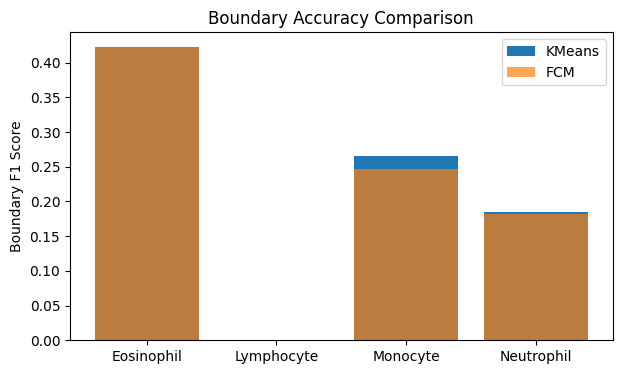

In [52]:
plt.figure(figsize=(7,4))
plt.bar(df["Cell"], df["KM Boundary F1"], label="KMeans")
plt.bar(df["Cell"], df["FCM Boundary F1"], alpha=0.7, label="FCM")
plt.ylabel("Boundary F1 Score")
plt.title("Boundary Accuracy Comparison")
plt.legend()
plt.show()

here i'll do that for entire data set so we can get the good picture of it properly.

In [53]:
def load_all_pairs(cell):

    img_paths = glob(os.path.join(ORIG,cell,"**","*.*"), recursive=True)
    mask_paths = glob(os.path.join(GT,cell,"**","*.*"), recursive=True)

    img_paths = sorted([p for p in img_paths if p.lower().endswith(('.png','.jpg','.jpeg','.bmp'))])
    mask_paths = sorted([p for p in mask_paths if p.lower().endswith(('.png','.jpg','.jpeg','.bmp'))])

    pairs = list(zip(img_paths, mask_paths))

    return pairs

In [54]:
results = []

for cell in cell_types:

    pairs = load_all_pairs(cell)

    km_scores = []
    fcm_scores = []

    print(f"\nProcessing {cell} → {len(pairs)} images")

    for img_path, mask_path in pairs:

        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        gt  = cv2.imread(mask_path,0)

        img = cv2.resize(img,(224,224))
        gt  = cv2.resize(gt,(224,224))

        wbc = extract_wbc(img)
        if wbc is None:
            continue

        gt_nucleus = (gt>128).astype(np.uint8)

        km_nuc,_ = kmeans_seg(img, wbc)
        fcm_nuc,_,_ = fcm_seg(img, wbc)

        km_scores.append(boundary_f1(km_nuc, gt_nucleus))
        fcm_scores.append(boundary_f1(fcm_nuc, gt_nucleus))

    # average per class
    results.append([
        cell,
        np.mean(km_scores),
        np.mean(fcm_scores)
    ])


Processing Eosinophil → 201 images

Processing Lymphocyte → 242 images

Processing Monocyte → 242 images

Processing Neutrophil → 242 images


In [55]:
df = pd.DataFrame(results,
                  columns=["Cell Type","KM Boundary F1","FCM Boundary F1"])

df

,Cell Type,KM Boundary F1,FCM Boundary F1
0,Eosinophil,0.259070,0.261393
1,Lymphocyte,0.205471,0.217644
2,Monocyte,0.235048,0.275372
3,Neutrophil,0.245316,0.226359


In [56]:
print("\nOverall Average Boundary F1")

print("KMeans :", round(df["KM Boundary F1"].mean(),3))
print("FCM    :", round(df["FCM Boundary F1"].mean(),3))


Overall Average Boundary F1
KMeans : 0.236
FCM    : 0.245


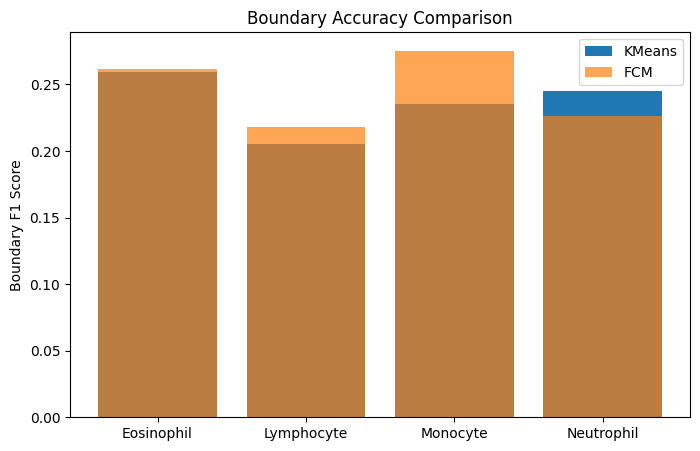

In [57]:
plt.figure(figsize=(8,5))
plt.bar(df["Cell Type"], df["KM Boundary F1"], label="KMeans")
plt.bar(df["Cell Type"], df["FCM Boundary F1"], alpha=0.7, label="FCM")
plt.ylabel("Boundary F1 Score")
plt.title("Boundary Accuracy Comparison")
plt.legend()
plt.show()